# Inference-Time Steering (ITS) — End-to-End Demo (Cursor-ready)

This notebook runs the entire pipeline on a **tiny model** so you can **Run All** in Cursor without using the terminal.

Pipeline:
- Download SemEval Task 11 train JSON
- Load a small model & dataset
- Build a **plausibility** steering vector (layer 10, last 16 tokens)
- Quick **alpha** search (ratio objective)
- Evaluate **baseline vs. steered**
- Trace one example end-to-end (log-probs / predictions)

> Open this notebook **inside the repo root** (where `itsteer/` lives). Then click **Run All**.



FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/its_pipeline_flowchart.png'

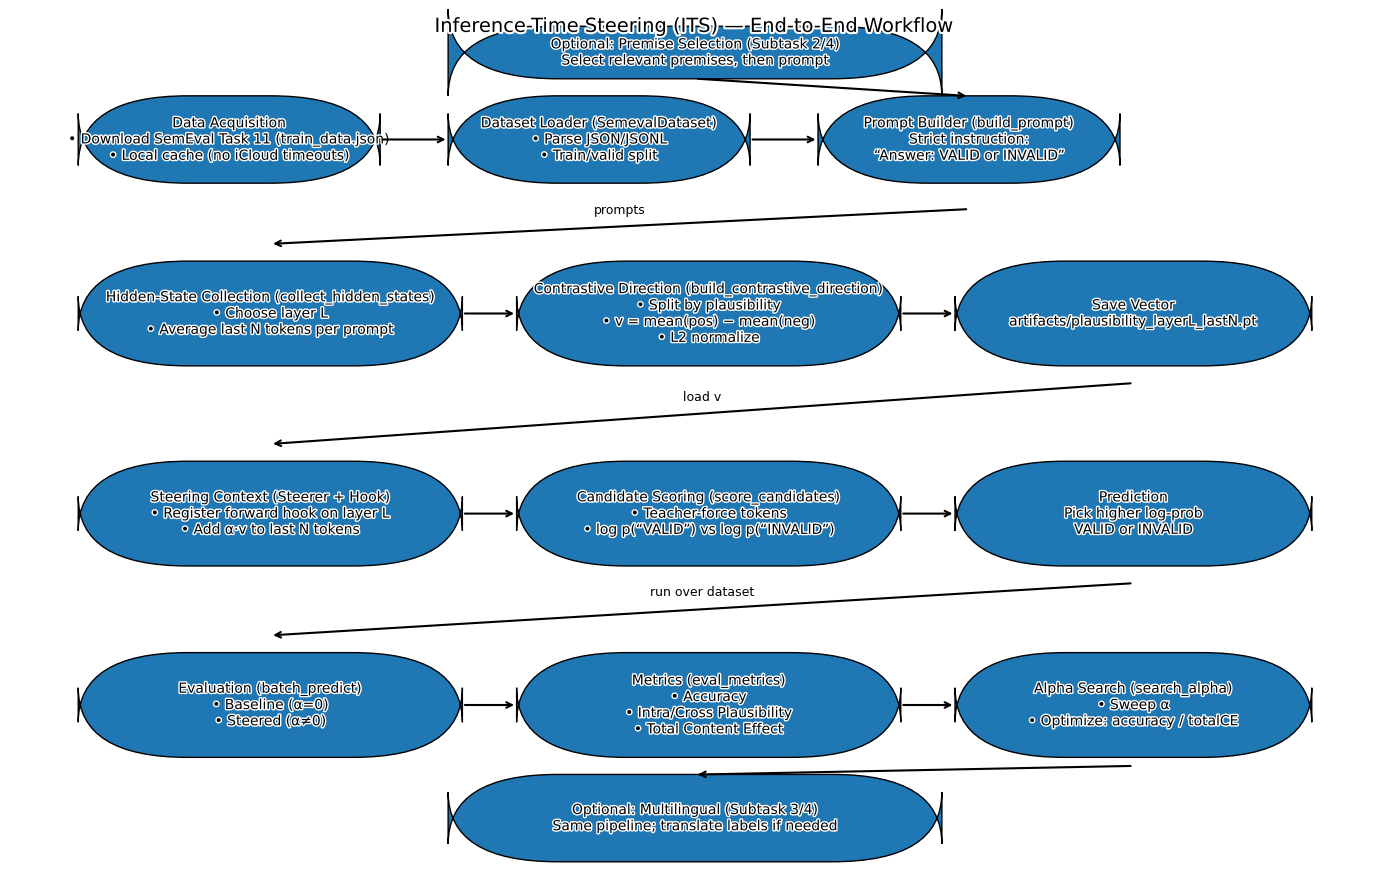

In [1]:
# Retry: generate the single-plot flowchart again.
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib import patheffects

fig = plt.figure(figsize=(14, 9))
ax = plt.gca()
ax.axis('off')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

def box(x, y, w, h, text, fontsize=10):
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=8")
    ax.add_patch(rect)
    tx = ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize, wrap=True)
    tx.set_path_effects([patheffects.Stroke(linewidth=2, foreground="white"), patheffects.Normal()])
    return (x + w/2, y + h/2)

def arrow(p_from, p_to, text=None, fontsize=9, dy=0):
    ax.annotate("", xy=(p_to[0], p_to[1]+dy), xytext=(p_from[0], p_from[1]+dy),
                arrowprops=dict(arrowstyle="->", lw=1.5))
    if text:
        ax.text((p_from[0]+p_to[0])/2, (p_from[1]+p_to[1])/2 + 2 + dy, text,
                ha='center', va='center', fontsize=fontsize)

# Lane A: Data & Prompting
c1 = box(5, 80, 22, 10, "Data Acquisition\n• Download SemEval Task 11 (train_data.json)\n• Local cache (no iCloud timeouts)")
c2 = box(32, 80, 22, 10, "Dataset Loader (SemevalDataset)\n• Parse JSON/JSONL\n• Train/valid split")
c3 = box(59, 80, 22, 10, "Prompt Builder (build_prompt)\nStrict instruction:\n“Answer: VALID or INVALID”")
arrow((c1[0]+11, c1[1]), (c2[0]-11, c2[1]))
arrow((c2[0]+11, c2[1]), (c3[0]-11, c3[1]))

# Lane B: Vector Build
c4 = box(5, 59, 28, 12, "Hidden-State Collection (collect_hidden_states)\n• Choose layer L\n• Average last N tokens per prompt")
c5 = box(37, 59, 28, 12, "Contrastive Direction (build_contrastive_direction)\n• Split by plausibility\n• v = mean(pos) − mean(neg)\n• L2 normalize")
c6 = box(69, 59, 26, 12, "Save Vector\nartifacts/plausibility_layerL_lastN.pt")
arrow((c3[0], c3[1]-8), (c4[0], c4[1]+8), "prompts")
arrow((c4[0]+14, c4[1]), (c5[0]-14, c5[1]))
arrow((c5[0]+14, c5[1]), (c6[0]-13, c6[1]))

# Lane C: Inference-Time Steering
c7 = box(5, 36, 28, 12, "Steering Context (Steerer + Hook)\n• Register forward hook on layer L\n• Add α·v to last N tokens")
c8 = box(37, 36, 28, 12, "Candidate Scoring (score_candidates)\n• Teacher-force tokens\n• log p(“VALID”) vs log p(“INVALID”)")
c9 = box(69, 36, 26, 12, "Prediction\nPick higher log-prob\nVALID or INVALID")
arrow((c6[0], c6[1]-8), (c7[0], c7[1]+8), "load v")
arrow((c7[0]+14, c7[1]), (c8[0]-14, c8[1]))
arrow((c8[0]+14, c8[1]), (c9[0]-13, c9[1]))

# Lane D: Evaluation & Tuning
c10 = box(5, 14, 28, 12, "Evaluation (batch_predict)\n• Baseline (α=0)\n• Steered (α≠0)")
c11 = box(37, 14, 28, 12, "Metrics (eval_metrics)\n• Accuracy\n• Intra/Cross Plausibility\n• Total Content Effect")
c12 = box(69, 14, 26, 12, "Alpha Search (search_alpha)\n• Sweep α\n• Optimize: accuracy / totalCE")
arrow((c9[0], c9[1]-8), (c10[0], c10[1]+8), "run over dataset")
arrow((c10[0]+14, c10[1]), (c11[0]-14, c11[1]))
arrow((c11[0]+14, c11[1]), (c12[0]-13, c12[1]))

# Optional branches
c13 = box(32, 92, 36, 6, "Optional: Premise Selection (Subtask 2/4)\nSelect relevant premises, then prompt")
c14 = box(32, 2, 36, 10, "Optional: Multilingual (Subtask 3/4)\nSame pipeline; translate labels if needed")
arrow((c13[0], c13[1]-3), (c3[0], c3[1]+5))
arrow((c12[0], c12[1]-7), (c14[0], c14[1]+5))

# Title
ax.text(50, 98, "Inference-Time Steering (ITS) — End-to-End Workflow", ha='center', va='center', fontsize=14,
        path_effects=[patheffects.Stroke(linewidth=3, foreground="white"), patheffects.Normal()])

out_path = "/mnt/data/its_pipeline_flowchart.png"
plt.tight_layout()
plt.savefig(out_path, dpi=180, bbox_inches="tight")
out_path

In [3]:
# === Cell 1: Environment sanity, add repo to sys.path, choose device (no pip) ===
import os, sys, json, time, math, random
from pathlib import Path

REPO_ROOT = Path.cwd()  # make sure the notebook is opened in repo root
assert (REPO_ROOT / "itsteer").exists(), f"Open the notebook in the repo root. Not found: {REPO_ROOT/'itsteer'}"
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("Python:", sys.version)
print("CWD   :", REPO_ROOT)

# Device pick (CUDA > MPS > CPU)
import torch
if torch.cuda.is_available():
    DEVICE = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print("Device:", DEVICE)

Python: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]
CWD   : /Users/ramnarayanchoudhary/Library/Mobile Documents/com~apple~CloudDocs/MS/LABS/NLP_701_Project/semeval_itsteer_repo
Device: mps


In [4]:
# === Cell 2 (REPLACE): Download train JSON to a LOCAL cache (not iCloud) ===
import os, json, shutil, subprocess, urllib.request, tempfile
from pathlib import Path

REPO_URL = "https://github.com/neuro-symbolic-ai/semeval_2026_task_11"
RAW_URL  = "https://raw.githubusercontent.com/neuro-symbolic-ai/semeval_2026_task_11/main/train_data/train_data.json"

# Local, non-iCloud cache dir
LOCAL_BASE = Path.home() / ".cache" / "semeval_itsteer"
LOCAL_BASE.mkdir(parents=True, exist_ok=True)
LOCAL_JSON = LOCAL_BASE / "train.json"

def looks_like_json(p: Path) -> bool:
    if not p.exists() or p.stat().st_size == 0:
        return False
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if s:
                return s.startswith("{") or s.startswith("[")
    return False

def fetch_to_local(out_path: Path):
    # 1) Try direct raw download
    try:
        print("Downloading:", RAW_URL)
        with urllib.request.urlopen(RAW_URL, timeout=30) as r, out_path.open("wb") as f:
            f.write(r.read())
        if looks_like_json(out_path):
            print("Saved ->", out_path)
            return
        else:
            print("Raw download didn't look like JSON; trying git clone fallback...")
    except Exception as e:
        print("Raw download failed:", e)

    # 2) Fallback: shallow clone and copy the file
    with tempfile.TemporaryDirectory() as tmpd:
        tmp = Path(tmpd)
        print("Cloning repo:", REPO_URL)
        subprocess.check_call(["git", "clone", "--depth", "1", REPO_URL, str(tmp/"task")])
        candidate = tmp/"task"/"train_data"/"train_data.json"
        if candidate.exists():
            shutil.copyfile(candidate, out_path)
            print("Copied ->", out_path)
        else:
            print("Could not find train_data.json; listing candidates:")
            for p in (tmp/"task").rglob("*train*.json*"):
                print(" -", p)
            raise FileNotFoundError("Train JSON not found in cloned repo.")

fetch_to_local(LOCAL_JSON)
assert looks_like_json(LOCAL_JSON), f"{LOCAL_JSON} is not valid JSON"
print("OK:", LOCAL_JSON)

Downloading: https://raw.githubusercontent.com/neuro-symbolic-ai/semeval_2026_task_11/main/train_data/train_data.json
Saved -> /Users/ramnarayanchoudhary/.cache/semeval_itsteer/train.json
OK: /Users/ramnarayanchoudhary/.cache/semeval_itsteer/train.json


In [5]:
# === Cell 3 (REPLACE): Load tiny model and the LOCAL dataset ===
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from itsteer.data import SemevalDataset
from itsteer.prompts import build_prompt, CLASS_LABELS
from pathlib import Path

MODEL  = "Qwen/Qwen2.5-0.5B-Instruct"   # tiny, laptop-friendly
LAYER  = 10
LAST_N = 16
MAX_LEN = 512

# Use the LOCAL_JSON produced by Cell 2
LOCAL_JSON = Path.home() / ".cache" / "semeval_itsteer" / "train.json"
assert LOCAL_JSON.exists(), f"Local dataset missing: {LOCAL_JSON}"

tok = AutoTokenizer.from_pretrained(MODEL)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

# Avoid the deprecation warning by not passing torch_dtype; then force dtype after load.
model = AutoModelForCausalLM.from_pretrained(MODEL)

# Pick device from your earlier Cell 1
try:
    model.to(DEVICE)
except NameError:
    DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
    model.to(DEVICE)

# On CPU/MPS, force float32 for stability
if DEVICE != "cuda":
    model.to(torch.float32)
model.eval()
print("Device:", DEVICE)

# Load dataset from LOCAL path (not iCloud)
ds = SemevalDataset(str(LOCAL_JSON))
print("Total examples:", len(ds.examples))
ex = ds.examples[0]
print("First example:", ex)

/Users/ramnarayanchoudhary/python_venvs/nlplab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps
Total examples: 960
First example: Example(id='50146f21-d265-4e3a-8d93-8165cdbe89a3', syllogism='All cars are a type of vehicle. No animal is a car. Therefore, no animal can be a vehicle.', validity=False, plausibility=True)


In [6]:
# === Cell 4: Baseline candidate log-probs for one example ===
from itsteer.eval_runner import score_candidates
from itsteer.prompts import build_prompt, CLASS_LABELS

prompt = build_prompt(ex.syllogism)
print("Prompt:\n", prompt.text)
print("Labels:", CLASS_LABELS)

logps_base = score_candidates(model, tok, prompt.text, candidates=CLASS_LABELS)
pred_base = CLASS_LABELS[0] if logps_base[0] > logps_base[1] else CLASS_LABELS[1]
print("Baseline log-probs:", dict(zip(CLASS_LABELS, logps_base)))
print("Baseline prediction:", pred_base)

Prompt:
 You are given a syllogism. Decide whether the conclusion follows from the premises by formal logic ALONE.
Ignore plausibility and world knowledge. Answer with exactly one of: VALID or INVALID.

Syllogism:
All cars are a type of vehicle. No animal is a car. Therefore, no animal can be a vehicle.

Answer: 
Labels: ['VALID', 'INVALID']
Baseline log-probs: {'VALID': -6.6670026779174805, 'INVALID': -5.8126373291015625}
Baseline prediction: INVALID


The below one is the simple activation steering using the Contrastive Activation Steering, i will do different type of activation steering using cast , knn based cast to analyzie the results 

In [ ]:
# === Cell 5: Build plausibility vector (subsample for speed) ===
from itsteer.vectorizers import collect_hidden_states, build_contrastive_direction
from itsteer.prompts import build_prompt
import random, torch, os
from pathlib import Path

LIMIT_PER_CLASS = 200    # tweak for speed/quality
BATCH_SIZE = 4           # safe on MPS
MAX_LEN = 512

texts_pos, texts_neg = [], []
for e in ds.examples:
    if e.plausibility is None:
        continue
    (texts_pos if e.plausibility else texts_neg).append(build_prompt(e.syllogism).text)

random.seed(0)
random.shuffle(texts_pos); random.shuffle(texts_neg)
if LIMIT_PER_CLASS:
    texts_pos = texts_pos[:LIMIT_PER_CLASS]
    texts_neg = texts_neg[:LIMIT_PER_CLASS]

print(f"Using {len(texts_pos)} pos / {len(texts_neg)} neg for vector build")

pos_hs = collect_hidden_states(
    model, tok, texts_pos,
    layer_idx=LAYER, pos_strategy=f"last_n_mean:{LAST_N}",
    batch_size=BATCH_SIZE, max_length=MAX_LEN
)
neg_hs = collect_hidden_states(
    model, tok, texts_neg,
    layer_idx=LAYER, pos_strategy=f"last_n_mean:{LAST_N}",
    batch_size=BATCH_SIZE, max_length=MAX_LEN
)

v = build_contrastive_direction(pos_hs, neg_hs, normalize=True).cpu()


# here we can construct v in many ways 
print("Vector dim:", v.numel())

ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(exist_ok=True)
VEC_PATH = ARTIFACTS / f"plausibility_layer{LAYER}_last{LAST_N}.pt"
torch.save({"vector": v, "meta": {"model": MODEL, "layer": LAYER, "last_n": LAST_N}, "dims": int(v.numel())}, VEC_PATH)
print("Saved ->", VEC_PATH)

Using 200 pos / 200 neg for vector build


collect@L10:   0%|          | 0/50 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
collect@L10: 100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


Vector dim: 896
Saved -> artifacts/plausibility_layer10_last16.pt


In [ ]:
# # 4) Build plausibility vector (fast subsample)
# from itsteer.vectorizers import collect_hidden_states, build_contrastive_direction
# import random
# LIMIT_PER_CLASS = 200
# texts_pos, texts_neg = [], []
# for e in ds.examples:
#     if e.plausibility is None: continue
#     (texts_pos if e.plausibility else texts_neg).append(build_prompt(e.syllogism).text)
# random.seed(0); random.shuffle(texts_pos); random.shuffle(texts_neg)
# texts_pos = texts_pos[:LIMIT_PER_CLASS]; texts_neg = texts_neg[:LIMIT_PER_CLASS]
# print(f'Using {len(texts_pos)} pos / {len(texts_neg)} neg')
# pos_hs = collect_hidden_states(model, tok, texts_pos, layer_idx=LAYER, pos_strategy=f'last_n_mean:{LAST_N}', batch_size=4, max_length=MAX_LEN)
# neg_hs = collect_hidden_states(model, tok, texts_neg, layer_idx=LAYER, pos_strategy=f'last_n_mean:{LAST_N}', batch_size=4, max_length=MAX_LEN)
# import torch
# v = build_contrastive_direction(pos_hs, neg_hs, normalize=True).cpu()
# print('Vector dim:', v.numel())
# import os
# os.makedirs('artifacts', exist_ok=True)
# VEC_PATH = f'artifacts/plausibility_layer{LAYER}_last{LAST_N}.pt'
# torch.save({'vector': v, 'meta': {'layer': LAYER, 'last_n': LAST_N, 'model': MODEL}, 'dims': int(v.numel())}, VEC_PATH)
# print('Saved ->', VEC_PATH)

Prompt:
 You are given a syllogism. Decide whether the conclusion follows from the premises by formal logic ALONE.
Ignore plausibility and world knowledge. Answer with exactly one of: VALID or INVALID.

Syllogism:
All cars are a type of vehicle. No animal is a car. Therefore, no animal can be a vehicle.


Without steering log-probs: {'VALID': -6.6670026779174805, 'INVALID': -5.8126373291015625}

With Steered log-probs: {'VALID': -6.590390205383301, 'INVALID': -5.775622367858887}


In [13]:
# === Cell 6: Steered candidate scoring for the same example ===
from itsteer.steering import Steerer
from itsteer.eval_runner import score_candidates

ALPHA = 1.0  # you can tune later
steerer = Steerer(model, layer_idx=LAYER, v=v, alpha=ALPHA, last_n=LAST_N)

with steerer.context():
    logps_steer = score_candidates(model, tok, prompt.text, candidates=CLASS_LABELS)

pred_steer = CLASS_LABELS[0] if logps_steer[0] > logps_steer[1] else CLASS_LABELS[1]
print("Steered log-probs:", dict(zip(CLASS_LABELS, logps_steer)))
print("Steered prediction:", pred_steer)

Steered log-probs: {'VALID': -6.590390205383301, 'INVALID': -5.775622367858887}
Steered prediction: INVALID


In [ ]:
# === Cell 7: Evaluate on a small slice (baseline vs steered) ===
from itsteer.eval_runner import batch_predict
from itsteer.eval_metrics import accuracy, content_effect_metrics

SLICE = 128  # small & fast
subset = ds.examples[:SLICE]
y_true = [e.validity for e in subset]
plaus  = [e.plausibility for e in subset]
sylls  = [e.syllogism for e in subset]

# Baseline
preds_b = batch_predict(model, tok, sylls)
mets_b = {"accuracy": accuracy(y_true, preds_b), **content_effect_metrics(y_true, preds_b, plaus)}

# Steered
steerer = Steerer(model, layer_idx=LAYER, v=v, alpha=ALPHA, last_n=LAST_N)
with steerer.context():
    preds_s = batch_predict(model, tok, sylls)
mets_s = {"accuracy": accuracy(y_true, preds_s), **content_effect_metrics(y_true, preds_s, plaus)}

def ratio(m): return m["accuracy"] / (m["total_content_effect"] + 1e-6)

print("BASELINE:", mets_b, "| ratio =", ratio(mets_b))
print("STEERED :", mets_s, "| ratio =", ratio(mets_s))

In [ ]:
# === Cell 7 (FAST): batched baseline vs steered on a tiny slice ===
import torch
from itsteer.steering import Steerer
from itsteer.eval_metrics import accuracy, content_effect_metrics

def batched_label_logprobs(model, tok, prompts, label_text, *, batch_size=16, max_length=384, device="cpu"):
    """
    Sum log-probs of `label_text` tokens given each prompt.
    Does 2*ceil(N/batch_size) forward passes total: once per label.
    """
    model.eval()
    label_ids = tok(label_text, add_special_tokens=False).input_ids
    label_ids_t = torch.tensor(label_ids, dtype=torch.long)

    all_scores = []
    with torch.no_grad():
        for i in range(0, len(prompts), batch_size):
            batch_prompts = prompts[i:i+batch_size]
            enc = tok(batch_prompts, add_special_tokens=False, padding=True, truncation=True,
                      max_length=max_length, return_tensors="pt")
            input_ids_prompt = enc["input_ids"]       # [B, T_p]
            attn_prompt     = enc["attention_mask"]   # [B, T_p]
            B = input_ids_prompt.size(0)
            # concatenate label tokens to each prompt
            label_rep = label_ids_t.unsqueeze(0).repeat(B, 1)  # [B, L]
            input_ids = torch.cat([input_ids_prompt, label_rep], dim=1)       # [B, T_p+L]
            attn_mask = torch.cat([attn_prompt, torch.ones_like(label_rep)], dim=1)

            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)

            out = model(input_ids, attention_mask=attn_mask)
            logits = out.logits  # [B, T, V]
            logp = torch.log_softmax(logits, dim=-1)

            # per-sample prompt lengths (without padding)
            prompt_lens = attn_prompt.sum(dim=1)  # [B]

            # sum log-probs for label tokens (positions shift by + (prompt_len-1))
            scores = []
            for b in range(B):
                start_pos = int(prompt_lens[b].item()) - 1  # first label token predicted after last prompt token
                s = 0.0
                for k, tok_id in enumerate(label_ids):
                    pos = start_pos + k
                    s += logp[b, pos, tok_id].item()
                scores.append(s)
            all_scores.extend(scores)
    return all_scores

# ---------- config for speed ----------
SLICE = 48             # much smaller than 128
BATCH = 16             # larger batch for throughput on MPS
MAX_LEN_EVAL = 384     # shorter context

subset = ds.examples[:SLICE]
y_true = [e.validity for e in subset]
plaus  = [e.plausibility for e in subset]
sylls  = [e.syllogism for e in subset]
prompts = [build_prompt(s).text for s in sylls]

# ---------- baseline ----------
valid_lp   = batched_label_logprobs(model, tok, prompts, "VALID",   batch_size=BATCH, max_length=MAX_LEN_EVAL, device=DEVICE)
invalid_lp = batched_label_logprobs(model, tok, prompts, "INVALID", batch_size=BATCH, max_length=MAX_LEN_EVAL, device=DEVICE)
preds_b = [ (v > i) for v, i in zip(valid_lp, invalid_lp) ]  # True => VALID, False => INVALID

mets_b = {
    "accuracy": accuracy(y_true, preds_b),
    **content_effect_metrics(y_true, preds_b, plaus),
}

# ---------- steered ----------
steerer = Steerer(model, layer_idx=LAYER, v=v, alpha=ALPHA, last_n=LAST_N)
with steerer.context():
    valid_lp_s   = batched_label_logprobs(model, tok, prompts, "VALID",   batch_size=BATCH, max_length=MAX_LEN_EVAL, device=DEVICE)
    invalid_lp_s = batched_label_logprobs(model, tok, prompts, "INVALID", batch_size=BATCH, max_length=MAX_LEN_EVAL, device=DEVICE)
preds_s = [ (v > i) for v, i in zip(valid_lp_s, invalid_lp_s) ]

mets_s = {
    "accuracy": accuracy(y_true, preds_s),
    **content_effect_metrics(y_true, preds_s, plaus),
}

def ratio(m): return m["accuracy"] / (m["total_content_effect"] + 1e-6)
print("BASELINE:", mets_b, "| ratio =", ratio(mets_b))
print("STEERED :", mets_s, "| ratio =", ratio(mets_s))

In [ ]:
# # 8) Tiny alpha sweep on dev split
# from itsteer.eval_metrics import accuracy, content_effect_metrics
# from itsteer.eval_runner import batch_predict
# import numpy as np
# train_split, valid_split = ds.train_valid_split(valid_frac=0.1)
# alphas = np.linspace(0.6, 1.2, 7)
# best = None
# for a in alphas:
#     st = Steerer(model, layer_idx=LAYER, v=v, alpha=float(a), last_n=LAST_N)
#     with st.context():
#         preds = batch_predict(model, tok, [e.syllogism for e in valid_split])
#     y = [e.validity for e in valid_split]
#     p = [e.plausibility for e in valid_split]
#     acc = accuracy(y, preds)
#     ce = content_effect_metrics(y, preds, p)
#     score = acc / (ce['total_content_effect'] + 1e-6)
#     print(f'alpha={a:.2f} -> acc={acc:.4f} totalCE={ce['total_content_effect']:.4f} score={score:.4f}')
#     if best is None or score > best[0]: best = (score, a, {'accuracy': acc, **ce})
# print('Best around 1.0:', best)